In [1]:
import sys, os

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))

In [2]:

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader
from langchain_community.embeddings import CohereEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_experimental.text_splitter import SemanticChunker
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CohereRerank
from langchain_community.llms import Cohere
from langchain.chains import RetrievalQA
from langchain.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.llms import OpenAI
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.document_loaders import Docx2txtLoader

In [ ]:
RecursiveCharacterTextSplitter, CharacterTextSplitter, SemanticChunker, 

In [4]:
from RAG_utils import load_document, load_documents_from_folder

/home/elias/miniconda/envs/langc/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.openai.OpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAI`.
  warn_deprecated(


In [5]:
import getpass
import os

# os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

In [5]:
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

In [6]:
folder_path = "../data/Evaluation Sets/contract"  # Replace with your folder path
all_documents = load_documents_from_folder(folder_path)

In [8]:
all_documents

[Document(page_content="[R&G Draft 12.__.2021]\n\n\t\t \n\n\t\t \n\n\n\n\n\n\n\nSTOCK PURCHASE AGREEMENT\n\nBY AND AMONG\n\n[BUYER],\n\n[TARGET COMPANY],\n\nTHE SELLERS LISTED ON SCHEDULE I HERETO\n\nAND\n\nTHE SELLERS’ REPRESENTATIVE NAMED HEREIN\n\nDated as of [●]\n\n\n\n[This document is intended solely to facilitate discussions among the parties identified herein.  Neither this document nor such discussions are intended to create, nor will either or both be deemed to create, a legally binding or enforceable offer or agreement of any type or nature, unless and until a definitive written agreement is executed and delivered by each of the parties hereto.\n\n\n\nThis document shall be kept confidential pursuant to the terms of the Confidentiality Agreement entered into by the parties and, if applicable, its affiliates with respect to the subject matter hereof.]\n\n\n\n\n\nTABLE OF CONTENTS\n\n\tARTICLE I DEFINITIONS; CERTAIN RULES OF CONSTRUCTION\t2\n\n\t\tSection 1.01\tDefinitions\t2\

In [8]:
sema_text_splitter = SemanticChunker(OpenAIEmbeddings(chunk_size=700))
sema_texts=sema_text_splitter.split_documents(all_documents)

In [ ]:
char_text_splitter = CharacterTextSplitter(chunk_size=700, chunk_overlap=50)
Char_texts = char_text_splitter.split_documents(all_documents)

In [10]:
recur_text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, chunk_overlap=50)
recurssive_texts = recur_text_splitter.split_documents(all_documents)

In [13]:
print("Length of sema_texts:", len(sema_texts))
print("Length of Char_texts:", len(Char_texts))
print("Length of recurssive_texts:", len(recurssive_texts))


Length of sema_texts: 37
Length of Char_texts: 316
Length of recurssive_texts: 466


In [24]:
sema_retriever = FAISS.from_documents(sema_texts, OpenAIEmbeddings()).as_retriever(
    search_kwargs={"k": 1}
)

In [ ]:
query = "WHO ARE THE PARTIES TO THE AGREEMENT AND WHAT ARE THEIR DEFINED NAMES? "
docs = sema_retriever.get_relevant_documents(query)
pretty_print_docs(docs)

In [30]:
char_retriever = FAISS.from_documents(sema_texts, OpenAIEmbeddings()).as_retriever(
    search_kwargs={"k": 1}
)

In [34]:
recur_retriever=FAISS.from_documents(sema_texts, OpenAIEmbeddings()).as_retriever(
    search_kwargs={"k": 1}
)

In [21]:
from langchain.chains import RetrievalQA

In [102]:
query=" WHO ARE THE PARTIES TO THE AGREEMENT AND WHAT ARE THEIR DEFINED NAMES? "

In [103]:
# chain = RetrievalQA.from_chain_type(
#     llm=Cohere(temperature=0), retriever=compression_retriever
# )

In [33]:
qa_sema = RetrievalQA.from_chain_type(llm=OpenAI(), chain_type="stuff", retriever=sema_retriever)
qa_recur= RetrievalQA.from_chain_type(llm=OpenAI(), chain_type="stuff", retriever=recur_retriever)
qa_char= RetrievalQA.from_chain_type(llm=OpenAI(), chain_type="stuff", retriever=char_retriever)

In [26]:
query = "How much is the escrow amount?"
qa_sema.run(query)

' The escrow amount is not specified in the context provided.'

In [35]:
qa_recur.run(query)

' The escrow amount is not specified in the given context. It is referenced multiple times, but the actual amount is not mentioned.'

In [36]:
qa_char.run(query)

' The escrow amount is not stated in the given context. '

## RAGAS

In [37]:
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain_openai import OpenAI

In [38]:
llm = OpenAI(temperature=0)

In [114]:
# compressor = LLMChainExtractor.from_llm(llm)
# compression_retriever = ContextualCompressionRetriever(
#     base_compressor=compressor, base_retriever=retriever
# )

In [39]:
import json

json_file="../evaluation_data/raptor_context.json"

with open(json_file, "r") as f:
    data = json.load(f)

questions, ground_truth = [], []

for item in data:
    if "question" in item:  # Check if "question" key exists
        questions.append(item["question"])
    if "answer" in item:  # Check if "answer" key exists
        ground_truth.append(item["answer"])

print("Questions:")
for question in questions:
    print(question)

print("\nGround Truth:")
for answer in ground_truth:
    print(answer)

Questions:
Under what circumstances and to what extent are the sellers responsible for a breach of representations and warranties?
Are Change of Control Payments considered a Seller Transaction Expense? ?
How much is the escrow amount?
WHO ARE THE PARTIES TO THE AGREEMENT AND WHAT ARE THEIR DEFINED NAMES?
WHAT IS THE TERMINATION NOTICE?
What are the payments to the Advisor under the Agreement?
Who owns the IP? 
What is the purpose of the escrow?
May the Escrow Amount serve as a recourse for the Buyer in case of breach of representations by the Company?

Ground Truth:
Except in the case of fraud, the sellers have no liability for breach of representations and warranties (See Section 10.01)
Yes. (See defining of Sellers Transaction Expenses).
The escrow amount is equal to $1,000,000.
CLOUD INVESTMENTS LTD. ("COMPANY") AND JACK ROBINSON ("ADVISOR")
According to section 4: 14 days for convenience by both parties. The Company may terminate without notice if the Advisor refuses or cannot per

In [40]:
import json

json_file="../evaluation_data/raptor_context.json"  # Replace with your actual path

with open(json_file, "r") as f:
    data = json.load(f)

questions = []  # List to store extracted questions
for item in data:
    if "question" in item:
        questions.append(item["question"])

## Semantic Chunking

In [41]:
context = []
for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question
    relevant_docs = sema_retriever.get_relevant_documents(processed_question)

    # Extract and store only page_content
    context.extend([doc.page_content for doc in relevant_docs])

# Now the context list contains only page_content strings
print(context)

['SURVIVAL; RECOURSE LIMITATIONS\n\nSurvival\n\n. The representations and warranties of the parties contained in this Agreement shall terminate automatically as of the Closing, and no Party or any of its Affiliates or its or their respective Representatives will have any recourse against the other party or any of its Affiliates or its or their respective Representatives with respect to such representations, warranties, covenants and agreements. The covenants and agreements contained in this Agreement that are to be performed after the Closing will survive the Closing in accordance with their terms. Notwithstanding anything in this Agreement (including in this \u200eSection 10.01 or \u200eSection 10.02) or otherwise to the contrary, nothing will limit or reduce Buyer’s ability to make claims or recover or receive any remedy from any Person with respect to claims arising from fraud committed by such Person. Recourse Limitations. Other than claims arising from fraud committed by the Perso

In [42]:
answers = []  # Create an empty list to store answers for each question
for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question and context (if needed)
    answer = qa_sema.run(processed_question)  # Include context if necessary

    # Append answer to the answers list
    answers.append(answer)

answers  # This will print a list of answers for each question

[' The sellers are responsible for a breach of representations and warranties until the Closing, after which they have no recourse against each other or any of their affiliates or representatives. However, the covenants and agreements that are to be performed after the Closing will survive the Closing in accordance with their terms. Additionally, the sellers are not responsible for any claims arising from fraud committed by a third party.',
 ' No, change of control payments are not considered a seller transaction expense. They are specifically excluded from the definition of seller transaction expenses.',
 ' The escrow amount is not specified in the context provided. It is mentioned that the Buyer will deposit the Escrow Amount at Closing, but the specific amount is not mentioned.',
 '\nThe parties to the agreement are the Buyer and the Seller. Their defined names are not specified in the context provided.',
 ' The termination notice is a written notice that must be delivered to the ot

In [119]:
print(type(answers))

<class 'list'>


In [43]:
context_lists = []

for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question
    relevant_docs = sema_retriever.get_relevant_documents(processed_question)

    # Create a new list for this question's context
    context_for_question = []

    # Extract and store only page_content (assuming Document has a page_content attribute)
    context_for_question.extend([doc.page_content for doc in relevant_docs])

    # Append the question's context list with only page_content to the main list
    context_lists.append(context_for_question)

# Now context_lists contains lists of page_content strings for each question

context_lists

[['SURVIVAL; RECOURSE LIMITATIONS\n\nSurvival\n\n. The representations and warranties of the parties contained in this Agreement shall terminate automatically as of the Closing, and no Party or any of its Affiliates or its or their respective Representatives will have any recourse against the other party or any of its Affiliates or its or their respective Representatives with respect to such representations, warranties, covenants and agreements. The covenants and agreements contained in this Agreement that are to be performed after the Closing will survive the Closing in accordance with their terms. Notwithstanding anything in this Agreement (including in this \u200eSection 10.01 or \u200eSection 10.02) or otherwise to the contrary, nothing will limit or reduce Buyer’s ability to make claims or recover or receive any remedy from any Person with respect to claims arising from fraud committed by such Person. Recourse Limitations. Other than claims arising from fraud committed by the Pers

In [44]:
ground_truths_lists = [[item] for item in ground_truth]

# Print the modified list of lists
print("Ground Truths (List of Lists):")
for sublist in ground_truths_lists:
    print(sublist)

Ground Truths (List of Lists):
['Except in the case of fraud, the sellers have no liability for breach of representations and warranties (See Section 10.01)']
['Yes. (See defining of Sellers Transaction Expenses).']
['The escrow amount is equal to $1,000,000.']
['CLOUD INVESTMENTS LTD. ("COMPANY") AND JACK ROBINSON ("ADVISOR")']
['According to section 4: 14 days for convenience by both parties. The Company may terminate without notice if the Advisor refuses or cannot perform the Services or is in breach of any provision of this Agreement.']
['According to section 6: 1. Fees of $9 per hour up to a monthly limit of $1,500, 2. Workspace expense of $100 per month, 3. Other reasonable and actual expenses if approved by the company in writing and in advance.']
['According to section 4 of the Undertaking (Appendix A), Any Work Product, upon creation, shall be fully and exclusively owned by the Company.']
['To serve as a recourse of the Buyer in case of post-closing adjustments of the purchase

In [45]:
from datasets import Dataset
semantic_data = {
    "question": questions, # list 
    "answer": answers, # list
    "contexts": context_lists, # list list
    "ground_truths": ground_truths_lists # list Lists
}

# Convert dict to dataset
dataset = Dataset.from_dict(semantic_data)

/home/elias/miniconda/envs/langc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = dataset, 
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
        
    ],
)

semantic_df = result.to_pandas()

passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`
Evaluating: 100%|██████████| 36/36 [00:32<00:00,  1.09it/s]


In [47]:
semantic_df

,question,answer,contexts,ground_truths,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy
0,Under what circumstances and to what extent ar...,The sellers are responsible for a breach of r...,[SURVIVAL; RECOURSE LIMITATIONS\n\nSurvival\n\...,"[Except in the case of fraud, the sellers have...","Except in the case of fraud, the sellers have ...",1.0,1.0,0.75,0.847804
1,Are Change of Control Payments considered a Se...,"No, change of control payments are not consid...","[Coronavirus Aid, Relief, and Economic Securit...",[Yes. (See defining of Sellers Transaction Exp...,Yes. (See defining of Sellers Transaction Expe...,1.0,1.0,NaN,0.984466
2,How much is the escrow amount?,The escrow amount is not specified in the con...,[Estimated Purchase Price. The Purchase Price ...,"[The escrow amount is equal to $1,000,000.]","The escrow amount is equal to $1,000,000.",0.0,0.0,NaN,0.907076
3,WHO ARE THE PARTIES TO THE AGREEMENT AND WHAT ...,\nThe parties to the agreement are the Buyer a...,[In the event an ambiguity or question of inte...,"[CLOUD INVESTMENTS LTD. (""COMPANY"") AND JACK R...","CLOUD INVESTMENTS LTD. (""COMPANY"") AND JACK RO...",0.0,1.0,NaN,0.934947
4,WHAT IS THE TERMINATION NOTICE?,The termination notice is a written notice th...,[SURVIVAL; RECOURSE LIMITATIONS\n\nSurvival\n\...,[According to section 4: 14 days for convenien...,According to section 4: 14 days for convenienc...,0.0,0.0,NaN,0.963793
5,What are the payments to the Advisor under the...,The payments to the advisor under the agreeme...,[NOW THEREFORE THE PARTIES AGREE AS FOLLOWS:\n...,[According to section 6: 1. Fees of $9 per hou...,According to section 6: 1. Fees of $9 per hour...,1.0,1.0,1.00,0.990384
6,Who owns the IP?,The Acquired Company owns all worldwide right...,[Scheduled Intellectual Property. Schedule 3.1...,[According to section 4 of the Undertaking (Ap...,According to section 4 of the Undertaking (App...,0.0,0.0,1.00,0.850344
7,What is the purpose of the escrow?,The purpose of the escrow is to hold funds in...,"[If any party has breached or violated, or if ...",[To serve as a recourse of the Buyer in case o...,To serve as a recourse of the Buyer in case of...,1.0,1.0,1.00,1.000000
8,May the Escrow Amount serve as a recourse for ...,"Yes, the escrow amount may serve as recourse ...","[If any party has breached or violated, or if ...",[No],No,0.0,0.0,0.50,0.949788


## Character splitter

In [55]:
import json

json_file="../evaluation_data/raptor_context.json"  # Replace with your actual path

with open(json_file, "r") as f:
    data = json.load(f)

questions = []  # List to store extracted questions
for item in data:
    if "question" in item:
        questions.append(item["question"])

In [56]:
context = []
for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question
    relevant_docs = char_retriever.get_relevant_documents(processed_question)

    # Extract and store only page_content
    context.extend([doc.page_content for doc in relevant_docs])

# Now the context list contains only page_content strings
print(context)

['SURVIVAL; RECOURSE LIMITATIONS\n\nSurvival\n\n. The representations and warranties of the parties contained in this Agreement shall terminate automatically as of the Closing, and no Party or any of its Affiliates or its or their respective Representatives will have any recourse against the other party or any of its Affiliates or its or their respective Representatives with respect to such representations, warranties, covenants and agreements. The covenants and agreements contained in this Agreement that are to be performed after the Closing will survive the Closing in accordance with their terms. Notwithstanding anything in this Agreement (including in this \u200eSection 10.01 or \u200eSection 10.02) or otherwise to the contrary, nothing will limit or reduce Buyer’s ability to make claims or recover or receive any remedy from any Person with respect to claims arising from fraud committed by such Person. Recourse Limitations. Other than claims arising from fraud committed by the Perso

In [57]:
answers = []  # Create an empty list to store answers for each question
for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question and context (if needed)
    answer = qa_char.run(processed_question)  # Include context if necessary

    # Append answer to the answers list
    answers.append(answer)

answers  # This will print a list of answers for each question

[' The sellers are not responsible for any breaches of representations and warranties after the closing, and they have limited recourse against each other or the buyer for any such breaches. However, the buyer still has the ability to make claims and recover remedies from the sellers for fraud committed by them.',
 ' Yes, change of control payments are considered a seller transaction expense under the context provided.',
 ' The escrow amount is not specified in the context provided.',
 ' The parties to the agreement are the Buyer and the Acquired Companies, and their defined names are not explicitly stated in the given context.',
 " The termination notice is the written notice required to terminate the appointment of the Sellers' Representative.",
 " The advisor will receive hourly fees at a rate of USD 9 per Billable Hour, limited to a maximum of USD 1,500 per month, as well as USD 100 per month for a workspace expense. They may also be reimbursed for reasonable and actual expenses in

In [58]:
context_lists = []

for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question
    relevant_docs = char_retriever.get_relevant_documents(processed_question)

    # Create a new list for this question's context
    context_for_question = []

    # Extract and store only page_content (assuming Document has a page_content attribute)
    context_for_question.extend([doc.page_content for doc in relevant_docs])

    # Append the question's context list with only page_content to the main list
    context_lists.append(context_for_question)

# Now context_lists contains lists of page_content strings for each question

context_lists

[['SURVIVAL; RECOURSE LIMITATIONS\n\nSurvival\n\n. The representations and warranties of the parties contained in this Agreement shall terminate automatically as of the Closing, and no Party or any of its Affiliates or its or their respective Representatives will have any recourse against the other party or any of its Affiliates or its or their respective Representatives with respect to such representations, warranties, covenants and agreements. The covenants and agreements contained in this Agreement that are to be performed after the Closing will survive the Closing in accordance with their terms. Notwithstanding anything in this Agreement (including in this \u200eSection 10.01 or \u200eSection 10.02) or otherwise to the contrary, nothing will limit or reduce Buyer’s ability to make claims or recover or receive any remedy from any Person with respect to claims arising from fraud committed by such Person. Recourse Limitations. Other than claims arising from fraud committed by the Pers

In [59]:
from datasets import Dataset
char_data = {
    "question": questions, # list 
    "answer": answers, # list
    "contexts": context_lists, # list list
    "ground_truths": ground_truths_lists # list Lists
}

# Convert dict to dataset
dataset = Dataset.from_dict(char_data)

In [60]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = dataset, 
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
        
    ],
)

char_df = result.to_pandas()

passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`
Evaluating: 100%|██████████| 36/36 [00:33<00:00,  1.07it/s]


In [61]:
char_df

,question,answer,contexts,ground_truths,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy
0,Under what circumstances and to what extent ar...,The sellers are not responsible for any breac...,[SURVIVAL; RECOURSE LIMITATIONS\n\nSurvival\n\...,"[Except in the case of fraud, the sellers have...","Except in the case of fraud, the sellers have ...",1.0,1.0,1.0,0.847822
1,Are Change of Control Payments considered a Se...,"Yes, change of control payments are considere...","[Coronavirus Aid, Relief, and Economic Securit...",[Yes. (See defining of Sellers Transaction Exp...,Yes. (See defining of Sellers Transaction Expe...,1.0,1.0,NaN,0.984466
2,How much is the escrow amount?,The escrow amount is not specified in the con...,[Estimated Purchase Price. The Purchase Price ...,"[The escrow amount is equal to $1,000,000.]","The escrow amount is equal to $1,000,000.",0.0,0.0,NaN,0.892041
3,WHO ARE THE PARTIES TO THE AGREEMENT AND WHAT ...,The parties to the agreement are the Buyer an...,[In the event an ambiguity or question of inte...,"[CLOUD INVESTMENTS LTD. (""COMPANY"") AND JACK R...","CLOUD INVESTMENTS LTD. (""COMPANY"") AND JACK RO...",0.0,1.0,NaN,0.000000
4,WHAT IS THE TERMINATION NOTICE?,The termination notice is the written notice ...,[SURVIVAL; RECOURSE LIMITATIONS\n\nSurvival\n\...,[According to section 4: 14 days for convenien...,According to section 4: 14 days for convenienc...,0.0,0.0,NaN,0.964389
5,What are the payments to the Advisor under the...,The advisor will receive hourly fees at a rat...,[NOW THEREFORE THE PARTIES AGREE AS FOLLOWS:\n...,[According to section 6: 1. Fees of $9 per hou...,According to section 6: 1. Fees of $9 per hour...,1.0,1.0,1.0,0.902215
6,Who owns the IP?,The Acquired Companies own the Intellectual P...,[Scheduled Intellectual Property. Schedule 3.1...,[According to section 4 of the Undertaking (Ap...,According to section 4 of the Undertaking (App...,0.0,0.0,1.0,0.870411
7,What is the purpose of the escrow?,The purpose of the escrow is to hold funds in...,"[If any party has breached or violated, or if ...",[To serve as a recourse of the Buyer in case o...,To serve as a recourse of the Buyer in case of...,1.0,1.0,1.0,1.000000
8,May the Escrow Amount serve as a recourse for ...,"Yes, the escrow amount can be used by the buy...","[If any party has breached or violated, or if ...",[No],No,0.0,0.0,0.0,0.946563


## Recuessive character splitter

In [68]:
import json

json_file="../evaluation_data/raptor_context.json"  # Replace with your actual path

with open(json_file, "r") as f:
    data = json.load(f)

questions = []  # List to store extracted questions
for item in data:
    if "question" in item:
        questions.append(item["question"])

In [69]:
context = []
for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question
    relevant_docs = recur_retriever.get_relevant_documents(processed_question)

    # Extract and store only page_content
    context.extend([doc.page_content for doc in relevant_docs])

# Now the context list contains only page_content strings
print(context)

['SURVIVAL; RECOURSE LIMITATIONS\n\nSurvival\n\n. The representations and warranties of the parties contained in this Agreement shall terminate automatically as of the Closing, and no Party or any of its Affiliates or its or their respective Representatives will have any recourse against the other party or any of its Affiliates or its or their respective Representatives with respect to such representations, warranties, covenants and agreements. The covenants and agreements contained in this Agreement that are to be performed after the Closing will survive the Closing in accordance with their terms. Notwithstanding anything in this Agreement (including in this \u200eSection 10.01 or \u200eSection 10.02) or otherwise to the contrary, nothing will limit or reduce Buyer’s ability to make claims or recover or receive any remedy from any Person with respect to claims arising from fraud committed by such Person. Recourse Limitations. Other than claims arising from fraud committed by the Perso

In [70]:
answers = []  # Create an empty list to store answers for each question
for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question and context (if needed)
    answer = qa_recur.run(processed_question)  # Include context if necessary

    # Append answer to the answers list
    answers.append(answer)

answers  # This will print a list of answers for each question

[" According to the context provided, the representations and warranties of the parties in the Agreement will terminate automatically at the Closing, and the Sellers will not have any recourse against the other party for any breaches of these representations and warranties. However, the covenants and agreements in the Agreement that are to be performed after the Closing will still survive and the Buyer can still make claims for fraud committed by the Sellers. Additionally, the Sellers' Representative may be held liable for actions or omissions in exercising their authority as outlined in the Agreement, but only in cases of gross negligence, bad faith, or willful misconduct. ",
 ' Yes, change of control payments are considered a seller transaction expense under the given context.',
 '\nThe escrow amount is not specified in the given context, so the answer cannot be determined.',
 '\nThe parties to the agreement are the "Buyer" and the "Acquired Companies." Their defined names are not ex

In [71]:
context_lists = []

for question in questions:
    # Preprocess question (e.g., lowercase, remove punctuation)
    processed_question = question.lower().strip()

    # Call retriever function with processed question
    relevant_docs = recur_retriever.get_relevant_documents(processed_question)

    # Create a new list for this question's context
    context_for_question = []

    # Extract and store only page_content (assuming Document has a page_content attribute)
    context_for_question.extend([doc.page_content for doc in relevant_docs])

    # Append the question's context list with only page_content to the main list
    context_lists.append(context_for_question)

# Now context_lists contains lists of page_content strings for each question

context_lists

[['SURVIVAL; RECOURSE LIMITATIONS\n\nSurvival\n\n. The representations and warranties of the parties contained in this Agreement shall terminate automatically as of the Closing, and no Party or any of its Affiliates or its or their respective Representatives will have any recourse against the other party or any of its Affiliates or its or their respective Representatives with respect to such representations, warranties, covenants and agreements. The covenants and agreements contained in this Agreement that are to be performed after the Closing will survive the Closing in accordance with their terms. Notwithstanding anything in this Agreement (including in this \u200eSection 10.01 or \u200eSection 10.02) or otherwise to the contrary, nothing will limit or reduce Buyer’s ability to make claims or recover or receive any remedy from any Person with respect to claims arising from fraud committed by such Person. Recourse Limitations. Other than claims arising from fraud committed by the Pers

In [72]:
from datasets import Dataset
recur_data = {
    "question": questions, # list 
    "answer": answers, # list
    "contexts": context_lists, # list list
    "ground_truths": ground_truths_lists # list Lists
}

# Convert dict to dataset
dataset = Dataset.from_dict(recur_data)

In [73]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset = dataset, 
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
        
    ],
)

recur_df = result.to_pandas()

passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`
Evaluating: 100%|██████████| 36/36 [00:34<00:00,  1.05it/s]


In [74]:
recur_df

,question,answer,contexts,ground_truths,ground_truth,context_precision,context_recall,faithfulness,answer_relevancy
0,Under what circumstances and to what extent ar...,"According to the context provided, the repres...",[SURVIVAL; RECOURSE LIMITATIONS\n\nSurvival\n\...,"[Except in the case of fraud, the sellers have...","Except in the case of fraud, the sellers have ...",1.0,1.0,1.00,0.779563
1,Are Change of Control Payments considered a Se...,"Yes, change of control payments are considere...","[Coronavirus Aid, Relief, and Economic Securit...",[Yes. (See defining of Sellers Transaction Exp...,Yes. (See defining of Sellers Transaction Expe...,1.0,1.0,NaN,0.984478
2,How much is the escrow amount?,\nThe escrow amount is not specified in the gi...,[Estimated Purchase Price. The Purchase Price ...,"[The escrow amount is equal to $1,000,000.]","The escrow amount is equal to $1,000,000.",0.0,0.0,NaN,0.000000
3,WHO ARE THE PARTIES TO THE AGREEMENT AND WHAT ...,"\nThe parties to the agreement are the ""Buyer""...",[In the event an ambiguity or question of inte...,"[CLOUD INVESTMENTS LTD. (""COMPANY"") AND JACK R...","CLOUD INVESTMENTS LTD. (""COMPANY"") AND JACK RO...",0.0,1.0,NaN,0.000000
4,WHAT IS THE TERMINATION NOTICE?,The termination notice is when the representa...,[SURVIVAL; RECOURSE LIMITATIONS\n\nSurvival\n\...,[According to section 4: 14 days for convenien...,According to section 4: 14 days for convenienc...,0.0,0.0,1.00,0.929883
5,What are the payments to the Advisor under the...,The payments to the advisor under the agreeme...,[NOW THEREFORE THE PARTIES AGREE AS FOLLOWS:\n...,[According to section 6: 1. Fees of $9 per hou...,According to section 6: 1. Fees of $9 per hour...,1.0,1.0,1.00,0.990385
6,Who owns the IP?,The Acquired Companies.,[Scheduled Intellectual Property. Schedule 3.1...,[According to section 4 of the Undertaking (Ap...,According to section 4 of the Undertaking (App...,0.0,0.0,1.00,0.747460
7,What is the purpose of the escrow?,\nThe purpose of the escrow is to hold funds i...,"[If any party has breached or violated, or if ...",[To serve as a recourse of the Buyer in case o...,To serve as a recourse of the Buyer in case of...,1.0,1.0,1.00,1.000000
8,May the Escrow Amount serve as a recourse for ...,"Yes, the escrow amount can serve as recourse ...","[If any party has breached or violated, or if ...",[No],No,0.0,0.0,0.25,0.902766


In [ ]:
import pandas as pd

# Calculate the mean of the specified metrics for each dataframe
recur_mean = recur_df[['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']].mean()
char_mean = char_df[['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']].mean()
semantic_mean = semantic_df[['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']].mean()

# Create dataframes for each mean value
recur_mean_df = pd.DataFrame(recur_mean, columns=['Recur Mean'])
char_mean_df = pd.DataFrame(char_mean, columns=['Char Mean'])
semantic_mean_df = pd.DataFrame(semantic_mean, columns=['Semantic Mean'])

# Concatenate the dataframes horizontally
mean_comparison_df = pd.concat([recur_mean_df, char_mean_df, semantic_mean_df], axis=1)

# Print the mean values for all dataframes in a single table horizontally
print(mean_comparison_df)


In [76]:
import pandas as pd

# Calculate the mean of the specified metrics for each dataframe
recur_mean = recur_df[['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']].mean()
char_mean = char_df[['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']].mean()
semantic_mean = semantic_df[['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']].mean()

# Create dataframes for each mean value
recur_mean_df = pd.DataFrame(recur_mean, columns=['Mean'])
char_mean_df = pd.DataFrame(char_mean, columns=['Mean'])
semantic_mean_df = pd.DataFrame(semantic_mean, columns=['Mean'])

# Print the mean values for each dataframe
print("Mean values for recur_df:")
print(recur_mean_df)

print("\nMean values for char_df:")
print(char_mean_df)

print("\nMean values for semantic_df:")
print(semantic_mean_df)



Mean values for recur_df:
                       Mean
context_precision  0.444444
context_recall     0.555556
faithfulness       0.875000
answer_relevancy   0.703837

Mean values for char_df:
                       Mean
context_precision  0.444444
context_recall     0.555556
faithfulness       0.800000
answer_relevancy   0.823101

Mean values for semantic_df:
                       Mean
context_precision  0.444444
context_recall     0.555556
faithfulness       0.850000
answer_relevancy   0.936511


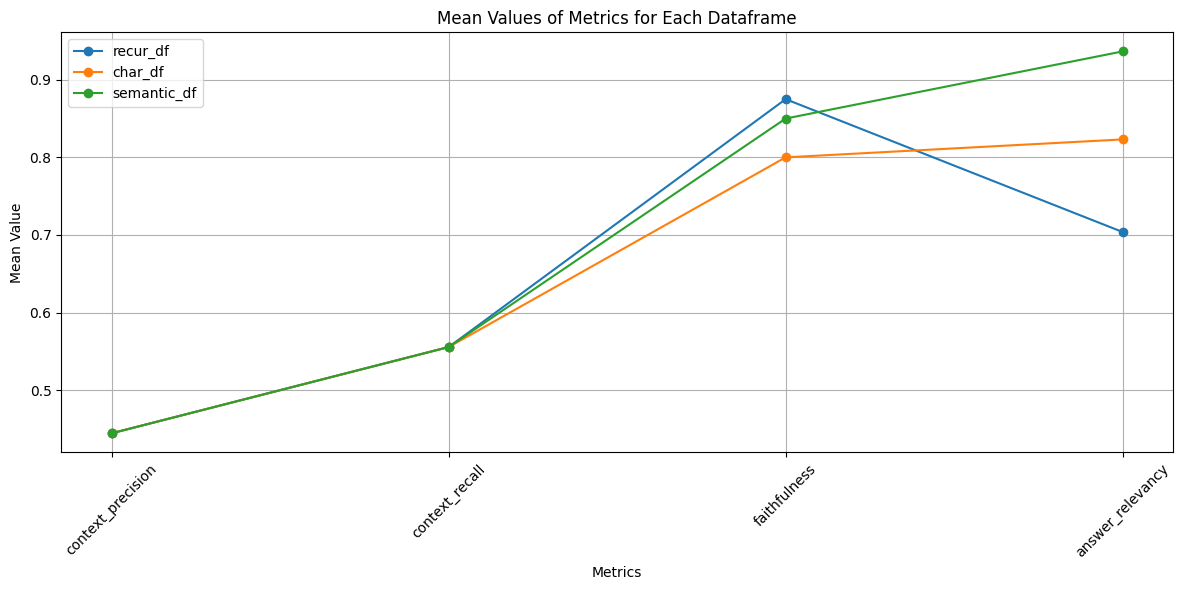

In [77]:
import matplotlib.pyplot as plt

# Calculate the mean of the specified metrics for each dataframe
recur_mean = recur_df[['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']].mean()
char_mean = char_df[['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']].mean()
semantic_mean = semantic_df[['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']].mean()

# Create dataframes for each mean value
recur_mean_df = pd.DataFrame(recur_mean, columns=['Mean'])
char_mean_df = pd.DataFrame(char_mean, columns=['Mean'])
semantic_mean_df = pd.DataFrame(semantic_mean, columns=['Mean'])

# Plotting the line graph
plt.figure(figsize=(12, 6))
plt.plot(recur_mean_df.index, recur_mean_df['Mean'], marker='o', label='recur_df')
plt.plot(char_mean_df.index, char_mean_df['Mean'], marker='o', label='char_df')
plt.plot(semantic_mean_df.index, semantic_mean_df['Mean'], marker='o', label='semantic_df')

plt.title('Mean Values of Metrics for Each Dataframe')
plt.xlabel('Metrics')
plt.ylabel('Mean Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the line graph
plt.show()
